In [ ]:
data.info()

In [24]:
savePath = "data.csv"

In [ ]:
from datetime import datetime
saveData(data, savePath + str(datetime.now()).replace(":", "-"))

Bóp tương tác: 179 -> 458 (bỏ 459, 460, 461, 462, 463)

In [1]:
# @title Connect to GDrive (DO NOT RUN)
import os
from google.colab import drive
MOUNTPOINT = '/content/drive'
DATADIR = os.path.join(MOUNTPOINT, 'MyDrive', 'Colab Notebooks')
drive.mount(MOUNTPOINT, force_remount = True)
%cd "drive/MyDrive/Colab Notebooks/temp/last"

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/temp/last


In [2]:
%pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00


In [3]:
# @title Imports
from collections import defaultdict
import copy
import pandas
import numpy
import seaborn
import matplotlib.pyplot as pyplot
import scipy
import random
import os
import sklearn
import xgboost
import lightgbm

import sklearn.linear_model
import sklearn.neighbors
import sklearn.tree
import sklearn.ensemble

import optuna

from wordcloud import WordCloud
from itertools import product

In [4]:
# @title Config
%matplotlib inline
seaborn.set(color_codes = True)
from warnings import simplefilter
simplefilter(action = "ignore", category=pandas.errors.PerformanceWarning)
simplefilter(action = "ignore", category=pandas.errors.SettingWithCopyWarning)

In [128]:
# @title Constants
DATA_FILE_PATH = "dataF4.csv"

TRAINING_LOSS_FUNCTION = "mean_absolute_error"

### Read Data from files

In [129]:
try:
    rawData = pandas.read_csv(DATA_FILE_PATH)
except:
    print("Could not read file")
    rawData = pandas.DataFrame()

In [130]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1869 entries, 0 to 1868
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   has_player_mention      1869 non-null   bool   
 1   is_umorous              1869 non-null   bool   
 2   is_controversial_topic  1869 non-null   bool   
 3   contains_good_deed      1869 non-null   bool   
 4   mention_match           1869 non-null   bool   
 5   reaction_count          1869 non-null   int64  
 6   image_count             1869 non-null   int64  
 7   has_with                1869 non-null   bool   
 8   has_link                1869 non-null   bool   
 9   Hour                    1869 non-null   int64  
 10  Day of week             1869 non-null   int64  
 11  Date                    1869 non-null   int64  
 12  Month                   1869 non-null   int64  
 13  avgLast5                1869 non-null   float64
 14  minLast5                1869 non-null   

### Extra functions

In [29]:
def oneHotBackToLabel(data, columns, newColumnName):
    columnSeries = pandas.Series(columns)

    encoder = sklearn.preprocessing.OneHotEncoder(sparse = False)
    encoder.fit_transform(columnSeries.to_numpy().reshape(-1, 1))

    newColumn = encoder.inverse_transform(data[sorted(columns)])
    newData = copy.deepcopy(data)
    newData[newColumnName] = [i[0] for i in newColumn]

    try:
        newData.drop(columns, axis = 1, inplace = True)
        print(columns, "dropped successfully from data")
    except Exception as error:
        print("Exception:", error)

    return newData

In [30]:
def convertToInt(data):
    newData = copy.deepcopy(data)

    for column in newData:
        if (newData[column].dtype == bool):
            newData[column] = newData[column].astype(int)
            #newData.drop(column, axis = 1, inplace = True)
            print(column, "converted to int")

    return newData

In [31]:
def printMetrics(model, testX, testY):
    print(sklearn.metrics.mean_absolute_percentage_error(testY, model.predict(testX)) * 100)
    print(sklearn.metrics.mean_absolute_error(testY, model.predict(testX)))

In [32]:
def saveData(data, path):
    data.to_csv(path, index = False)

In [33]:
def yRegressionToClassification(trainData, testData, n, column):
    newTrainData = copy.deepcopy(trainData)
    newTestData = copy.deepcopy(testData)

    newTrainData.reset_index(drop = True, inplace = True)
    newTestData.reset_index(drop = True, inplace = True)

    newTrainData["new_column"] = ""
    newTestData["new_column"] = ""

    lengthOfEachLabel = len(newTrainData.index) / n

    newTrainData = newTrainData.sort_values(by = [column], ascending = [True])

    cutOffValues = list()

    for i in range(n):
        cutOffValues.append(round(newTrainData[column].iloc[int(round(i * lengthOfEachLabel, 0) - 1)] / 2 + newTrainData[column].iloc[int(round(i * lengthOfEachLabel, 0))] / 2, 3))

    cutOffValues[0] = 0
    cutOffValues.append("")

    for i in range(n):
        newTrainData["new_column"].iloc[int(round(i * lengthOfEachLabel, 0)):int(round((i + 1) * lengthOfEachLabel, 0))] = str(cutOffValues[i]) + "-" + str(cutOffValues[i + 1])

    for i, row in newTestData.iterrows():
        for j in range(1, n):
            if newTestData[column].iloc[i] < cutOffValues[j]:
                newTestData["new_column"].iloc[i] = str(cutOffValues[j - 1]) + "-" + str(cutOffValues[j])
                break

        if newTestData["new_column"].iloc[i] == "":
                newTestData["new_column"].iloc[i] = str(cutOffValues[n - 1]) + "-" + str(cutOffValues[n])

    newTrainData.sort_index(inplace = True)
    return newTrainData["new_column"], newTestData["new_column"]

### Dropping columns

In [155]:
droppedColumns = rawData.columns[37:]

try:
    rawData.drop(droppedColumns, axis = 1, inplace = True)
    print(droppedColumns, "dropped successfully from data")
except Exception as error:
    print("Exception:", error)

Index(['trận_counts', 'đội_counts', 'mùa_counts', 'hlv_counts',
       'ten_hag_counts', 'cầu_thủ_counts', 'bàn_counts', 'sân_counts',
       'giải_counts', 'bóng_counts', 'đấu_counts', 'premier_league_counts',
       'onana_counts', 'dự_counts', 'chính_thức_counts', 'đêm_counts',
       'rashford_counts', 'ghi_counts', 'maguire_counts', 'quỷ_đỏ_counts',
       'kiến_counts', 'old_trafford_counts', 'chấn_thương_counts',
       'sancho_counts', 'ronaldo_counts', 'kết_counts', 'greenwood_counts',
       'de_gea_counts', 'triệu_counts', 'hàng_counts', 'hè_counts',
       'trai_counts', 'báo_counts', 'clb_counts', 'bảng_counts', 'vệ_counts',
       'bruno_counts', 'chúc_mừng_counts', 'thủ_counts', 'top_counts',
       'luyện_counts', 'tỷ_counts', 'antony_counts', 'mount_counts',
       'hojlund_counts', 'mua_counts', 'chủ_counts', 'thông_counts',
       'casemiro_counts', 'vọng_counts'],
      dtype='object') dropped successfully from data


In [328]:
droppedColumns = ["url", "comment_count", "reactions", "comments_text", "date", "time", "text", "share_count", "has_image"]

try:
    rawData.drop(droppedColumns, axis = 1, inplace = True)
    print(droppedColumns, "dropped successfully from data")
except Exception as error:
    print("Exception:", error)

['url', 'comment_count', 'reactions', 'comments_text', 'date', 'time', 'text', 'share_count', 'has_image'] dropped successfully from data


In [169]:
droppedColumns = ["has_link", "minAllTime", "maxAllTime", "has_image", "Year", "minAllTime", "maxAllTime", "capitalized", "captionLength"]

try:
    rawData.drop(droppedColumns, axis = 1, inplace = True)
    print(droppedColumns, "dropped successfully from data")
except Exception as error:
    print("Exception:", error)

['has_link', 'minAllTime', 'maxAllTime', 'has_image', 'Year', 'minAllTime', 'maxAllTime', 'captionLength', 'emoji', 'number'] dropped successfully from data


### Feature engineering

object to boolean

In [308]:
def objectToBoolean(data):
    newData = copy.deepcopy(data)

    tempDataFrame = pandas.DataFrame(index = numpy.arange(len(newData.index)))
    objectButBooleanColumns = ["has_player_mention", "is_umorous", "is_controversial_topic", "contains_good_deed", "mention_match"]

    for column in objectButBooleanColumns:
        tempDataFrame[column] = True

        for i, row in newData.iterrows():
            tempDataFrame[column].iloc[i] = newData[column].iloc[i] == "True" or newData[column].iloc[i] == "TRUE" or newData[column].iloc[i] == "true" or newData[column].iloc[i] == "1" or newData[column].iloc[i] == 1

        newData[column] = tempDataFrame[column]
    return newData

data = objectToBoolean(rawData)

Hour, day of week, date, month, year of posting time, of a post

In [ ]:
usefulColumns = ["reaction_count", "avgAllTime", "avgLast5", "minLast5", "maxLast5", "Hour", "Day of week", "Date", "Month", "capitalized", "captionLength"]

data[usefulColumns].iloc[:30]

In [307]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1874 entries, 0 to 1873
Data columns (total 62 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   url                     1874 non-null   object
 1   text                    1874 non-null   object
 2   has_player_mention      1874 non-null   bool  
 3   is_umorous              1874 non-null   bool  
 4   is_controversial_topic  1874 non-null   bool  
 5   contains_good_deed      1874 non-null   bool  
 6   mention_match           1874 non-null   bool  
 7   comment_count           1874 non-null   int64 
 8   share_count             1874 non-null   int64 
 9   reactions               1874 non-null   object
 10  reaction_count          1874 non-null   int64 
 11  was_live                1874 non-null   bool  
 12  fanpage_name            1874 non-null   object
 13  image_count             1874 non-null   int64 
 14  has_image               1874 non-null   bool  
 15  has_

In [ ]:
rawData.info()

In [ ]:
data["time"]

0       06:58:00 AM
1       08:15:00 AM
2       09:00:00 AM
3       11:00:00 AM
4       12:00:00 PM
           ...     
1869    08:24:00 AM
1870    09:09:00 AM
1871    11:30:00 AM
1872    05:04:00 PM
1873    07:26:00 PM
Name: time, Length: 1874, dtype: object

In [296]:
def textToDateTime(data):
    newData = copy.deepcopy(data)

    newData["Hour"] = None
    newData["Day of week"] = None
    newData["Date"] = None
    newData["Month"] = None

    droppedIndicies = list()

    for i, row in newData.iterrows():
        newData["Hour"].iloc[i] = int(row["time"][:2])
        newData["Date"].iloc[i] = int(row["date"][:2])
        newData["Month"].iloc[i] = int(row["date"][3:5])

        if (row["time"][len(row["time"])-2:] == "PM"):
            newData["Hour"].iloc[i] = newData["Hour"].iloc[i] + 12

        if newData["Hour"].iloc[i] == 24:
            newData["Hour"].iloc[i] = 0

        weekday = pandas.to_datetime(row["date"], dayfirst=True).weekday()

        if (weekday == 0):
            newData["Day of week"].iloc[i] = "Monday"
        elif (weekday == 1):
            newData["Day of week"].iloc[i] = "Tuesday"
        elif (weekday == 2):
            newData["Day of week"].iloc[i] = "Wednesday"
        elif (weekday == 3):
            newData["Day of week"].iloc[i] = "Thursday"
        elif (weekday == 4):
            newData["Day of week"].iloc[i] = "Friday"
        elif (weekday == 5):
            newData["Day of week"].iloc[i] = "Saturday"
        elif (weekday == 6):
            newData["Day of week"].iloc[i] = "Sunday"

        if (i % 100 == 0):
            print(i, end = " ")

        if (newData["Hour"].iloc[i] == None or newData["Day of week"].iloc[i] == None or newData["Date"].iloc[i] == None or newData["Month"].iloc[i] == None):
            print(row)
            droppedIndicies.append(i)
    print()
    print(droppedIndicies)

    newData["Hour"] = newData["Hour"].astype(int)
    newData["Date"] = newData["Date"].astype(int)
    newData["Month"] = newData["Month"].astype(int)

    return newData

data = textToDateTime(data)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 
[]


Average, min, max number of likes of the last $n$ post of a user

In [297]:
def minMaxAvgLastN(data, n):
    newData = copy.deepcopy(data)

    newData["avgLast" + str(n)] = None
    newData["minLast" + str(n)] = None
    newData["maxLast" + str(n)] = None

    newData.sort_values(by = ["date", "time"], ascending = [True, True])

    droppedIndicies = list()

    for i, row in newData.iterrows():
        if (i < 5 or (i >= 179 and i < 464)):
            droppedIndicies.append(i)
            continue

        newData["avgLast" + str(n)].iloc[i] = newData["reaction_count"].iloc[i-5:i].mean()
        newData["minLast" + str(n)].iloc[i] = newData["reaction_count"].iloc[i-5:i].min()
        newData["maxLast" + str(n)].iloc[i] = newData["reaction_count"].iloc[i-5:i].max()

        if (i % 100 == 0):
            print(i, end = " ")

        if (newData["avgLast" + str(n)].iloc[i] == None or newData["minLast" + str(n)].iloc[i] == None or newData["maxLast" + str(n)].iloc[i] == None):
            print(row)
            droppedIndicies.append(i)
    print()

    newData = newData.sort_index()
    print(droppedIndicies)

    return newData

data = minMaxAvgLastN(data, 5)

100 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 
[0, 1, 2, 3, 4, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361,

Average, min, max number of likes of all time of a user (in the past)

In [298]:
def minMaxAvgAllTime(data):
    newData = copy.deepcopy(data)

    newData["avgAllTime"] = None
    #newData["minAllTime"] = None
    #newData["maxAllTime"] = None

    newData.sort_values(by = ["date", "time"], ascending = [True, True])

    droppedIndicies = list()

    for i, row in newData.iterrows():
        if (i < 5 or (i >= 179 and i < 464)):
            droppedIndicies.append(i)
            continue

        if (i > 178):
            index = numpy.r_[:179, 464:i]
        else:
            index = numpy.r_[:i]

        newData["avgAllTime"].iloc[i] = newData["reaction_count"].iloc[index].mean()
        #newData["minAllTime"].iloc[i] = newData["reaction_count"].iloc[index].min()
        #newData["maxAllTime"].iloc[i] = newData["reaction_count"].iloc[index].max()
        if (i % 100 == 0):
            print(i, end = " ")

        if (newData["avgAllTime"].iloc[i] == None):
            print(row)
            droppedIndicies.append(i)
    print()

    print(droppedIndicies)

    newData = newData.sort_index()

    return newData

data = minMaxAvgAllTime(data)

100 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 
[0, 1, 2, 3, 4, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361,

Capitalized percentage of a post

In [299]:
def capitalizedPercentage(data):
    import re

    letters = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZàáảãạăằắẳẵặâầấẩẫậđèéẻẽẹêềếểễệìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠĂẰẮẲẴẶÂẦẤẨẪẬĐÈÉẺẼẸÊỀẾỂỄỆÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴ')

    def uses_other_chars(s):
        return set(s) <= letters

    def useCapializedLetters(s):
        return re.search('[ABCDEFGHIJKLMNOPQRSTUVWXYZÀÁẢÃẠĂẰẮẲẴẶÂẦẤẨẪẬĐÈÉẺẼẸÊỀẾỂỄỆÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴ]', s)

    specialCharacters = "`~!@#$%^&*()_-=+[{;:\'\"\\|/?.<>,}]"

    newData = copy.deepcopy(data)

    newData["capitalized"] = None

    droppedIndicies = list()

    for i, row in newData.iterrows():
        totalWords = ''.join(idx if idx not in specialCharacters else "" for idx in row["text"].split("\r\n\r\nTRANGCUOCSONG24H.COM\r\n")[0].split("\r\n")[0]).split(" ")
        totalWords = [i for i in totalWords if uses_other_chars(i)]
        totalWords = [i for i in totalWords if i]

        capitalizedWords = [i for i in totalWords if useCapializedLetters(i)]

        newData["capitalized"].iloc[i] = len(capitalizedWords) / len(totalWords) if len(totalWords) != 0 else 0

        if (i % 100 == 0):
            print(i, end = " ")

        if (newData["capitalized"].iloc[i] == None):
            print(row)
            droppedIndicies.append(i)
    print()

    print(droppedIndicies)

    return newData

data = capitalizedPercentage(data)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 
[]


Caption length of a post

In [300]:
def captionLength(data):
    newData = copy.deepcopy(data)

    newData["captionLength"] = None

    specialCharacters = "`~!@#$%^&*()_-=+[{;:\'\"\\|/?.<>,}]"

    letters = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZàáảãạăằắẳẵặâầấẩẫậđèéẻẽẹêềếểễệìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠĂẰẮẲẴẶÂẦẤẨẪẬĐÈÉẺẼẸÊỀẾỂỄỆÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴ0123456789')

    droppedIndicies = list()

    def uses_other_chars(s):
        return set(s) <= letters

    for i, row in newData.iterrows():
        totalWords = ''.join(idx if idx not in specialCharacters else "" for idx in row["text"].split("\r\n\r\nTRANGCUOCSONG24H.COM\r\n")[0].split("\r\n")[0]).split(" ")
        totalWords = [i for i in totalWords if uses_other_chars(i)]
        totalWords = [i for i in totalWords if i]

        newData["captionLength"].iloc[i] = len(totalWords)

        if (i % 100 == 0):
            print(i, end = " ")

        if (newData["captionLength"].iloc[i] == None):
            print(row)
            droppedIndicies.append(i)
    print()

    print(droppedIndicies)

    return newData

data = captionLength(data)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 
[]


$n$ most common words count

In [301]:
def topNWords(data, n):
    newData = copy.deepcopy(data)

    stopWordsFile = open("vietnamese-stopwords.txt", "r")
    stopWordsFileContent = stopWordsFile.readlines()
    stopWordsFile.close()

    stopWords = set()

    for line in stopWordsFileContent:
        stopWords.update(line.split())

    stopWords.add("chàng")

    wordData = dict()

    import re

    string1 = " abcdefghijklmnopqrstuvwxyzàáảãạăằắẳẵặâầấẩẫậđèéẻẽẹêềếểễệìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵ"
    string2 = "_ABCDEFGHIJKLMNOPQRSTUVWXYZÀÁẢÃẠĂẰẮẲẴẶÂẦẤẨẪẬĐÈÉẺẼẸÊỀẾỂỄỆÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴ"

    wordReplacementDict = {
        'giải nghệ': 'giải_nghệ',
        'manchester united': 'man united',
        'man united': 'man utd',
        'man utd': 'mu',
        'premier league': 'epl',
        'epl': 'premier_league',
        'marcus rashford': 'rashford',
        'marcus': 'rashford',
        'erik ten hag': 'ten hag',
        'ten hag': 'ten_hag',
        'harry maguire': 'maguire',
        'mason greenwood': 'greenwood',
        'mason mount': 'mason_mount',
        'old trafford': 'old_trafford',
        'de gea': 'de_gea',
        'sir alex': 'sir_alex',
        'thông báo': 'thông_báo',
        'hàng tiền đạo': 'tiền đạo',
        'tiền đạo': 'tiền_đạo',
        'chúc mừng': 'chúc_mừng',
        'bảng xếp hạng': 'bxh',
        'bảng đấu': 'bxh',
        'hàng thủ': 'hậu vệ',
        'hàng hậu vệ': 'hậu vệ',
        'hậu vệ': 'hậu_vệ',
        'quỷ đỏ': 'quỷ_đỏ',
        'hàng tiền vệ': 'tiền vệ',
        'tiền vệ': 'tiền_vệ',
        'chính thức': 'chính_thức',
        'chiến đấu': 'chiến_đấu',
        'chiến thắng': 'chiến_thắng',
        'đối thủ': 'đối_thủ',
        'thi đấu': 'thi_đấu',
        'trận đấu': 'trận',
        'trận': 'trận_đấu',
        'giải đấu': 'giải_đấu',
        'cầu thủ': 'cầu_thủ',
        'chấn thương': 'chấn_thương',
        'thông báo': 'thông_báo',
        'rasmus hojlund': 'hojlund',
        'tham dự': 'tham_dự',
        'dự kiến': 'dự_kiến',
        'ghi bàn': 'bàn',
        'bàn thắng': 'bàn',
        'bàn': 'bàn_thắng',
        'kì vọng': 'kì_vọng',
        'kỳ vọng': 'kì_vọng',
        'đội bóng': 'đội_bóng',
        'kết quả': 'kết_quả',
        'kết thúc': 'kết_thúc',
        'kết liễu': 'kết_liễu',
        'thất vọng': 'thất_vọng',
        'triệu tập': 'triệu_tập',
        'thông tin': 'thông_tin',
        'sân nhà': 'sân_nhà',
        'sân bóng': 'sân',
        'bóng đá': 'bóng_đá',
        'đá bóng': 'đá_bóng',
        'báo thủ': 'báo_thủ',
        'con hàng': 'con_hàng',
        'tập luyện': 'tập_luyện',
        'hlv': 'huấn luyện viên',
        'huấn luyện viên': 'huấn_luyện_viên',
        'mùa hè': 'mùa_hè',
        'mùa mùa_hè': 'mùa_hè',
        'mùa đông': 'mùa_đông',
        'mùa mùa_đông': 'mùa_đông',
        'mùa bóng': 'mùa giải',
        'mùa giải': 'mùa_giải',
        'xuân': 'mùa xuân',
        'mùa xuân': 'mùa_xuân',
        'mùa mùa_xuân': 'mùa_xuân',
        'mùa thu': 'mùa_thu',
        'mùa mùa_thu': 'mùa_thu',
        'mùa bóng': 'mùa_giải',
        'bóng': 'quả_bóng',
        'quả quả_bóng': 'quả_bóng',
        'đội_quả_bóng': 'đội_bóng',
        'mùa ': 'mùa_giải',
        'này': '',
        'triệu bảng': 'triệu_bảng',
        'triệu euro': 'triệu_bảng',
        'triệu usd': 'triệu_bảng',
        'chàng trai': 'chàng_trai',
        'cảnh báo': 'cảnh_báo',
        'họp báo': 'họp_báo',
        'báo cáo': 'báo_cáo',
        'nhà báo': 'báo_chí',
        'báo anh': 'báo_chí',
        'báo hà lan': 'báo_chí',
        'bài báo': 'báo_chí',
        'báo chí': 'báo_chí',
        'tỷ số': 'tỉ_số',
        'tỉ số': 'tỉ_số',
        'tỷ lệ': 'tỉ_lệ',
        'thủ môn': 'thủ_môn',
        'danh thủ': 'danh_thủ',
        'tuyển thủ': 'cầu_thủ',
        'thủ thành': 'thủ_môn',
        'hàng đầu': 'hàng_đầu',
        'hàng công': 'tiền_đạo',
        'hàng loạt': 'hàng_loạt',
        'đội tuyển': 'đội_tuyển',
        'đội khách': 'đội_khách',
        'đội hình': 'đội_hình',
        'đồng đội': 'đồng_đội',
        'đội chủ': 'đội bóng chủ',
        'đội bạn': 'đội_bạn',
        'đội đầu': 'đội_đầu',
        'đội trưởng': 'đội_trưởng',
        ' đội ': ' đội_bóng'
    }

    specialCharacters = "`~!@#$%^&*()-=+[{;:\'\"\\|/?.<>,}]"
    commonWords = list(stopWords)

    letters = set(string1 + string2)

    lettersMap = dict()

    for i in range(len(string1)):
        lettersMap[string2[i]] = string1[i]

    def uses_other_chars(s):
        return set(s) <= letters

    for i, row in newData.iterrows():
        totalWords = ''.join(idx if idx not in specialCharacters else "" for idx in ''.join(idy if idy not in lettersMap else lettersMap[idy] for idy in row["text"].split("\r\n\r\nTRANGCUOCSONG24H.COM\r\n")[0].split("\r\n")[0]))
        for key, value in wordReplacementDict.items():
            totalWords = totalWords.replace(key, value)

        totalWords = totalWords.split()

        totalWords = [i for i in totalWords if uses_other_chars(i)]
        totalWords = [i for i in totalWords if i]

        for word in totalWords:
            if word not in commonWords:
                wordData[word] = wordData.get(word, 0) + 1

    topWords = list(dict(sorted(wordData.items(), key=lambda item: item[1], reverse = True)).keys())[:n]

    for word in topWords:
        newData[word] = False

    for i, row in newData.iterrows():
        totalWords = ''.join(idx if idx not in specialCharacters else "" for idx in ''.join(idy if idy not in lettersMap else lettersMap[idy] for idy in row["text"].split("\r\n\r\nTRANGCUOCSONG24H.COM\r\n")[0].split("\r\n")[0]))
        for key, value in wordReplacementDict.items():
            totalWords = totalWords.replace(key, value)

        totalWords = totalWords.split()

        totalWords = [i for i in totalWords if uses_other_chars(i)]
        totalWords = [i for i in totalWords if i]

        for word in totalWords:
            if word in topWords:
                newData[word].iloc[i] = True

        if (i % 100 == 0):
            print(i, end = " ")
    print()

    return newData
data = topNWords(data, 30)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 


Number of emojis of a post

In [ ]:
def emojiNumber(data):
    import re
    letters = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZàáảãạăằắẳẵặâầấẩẫậđèéẻẽẹêềếểễệìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠĂẰẮẲẴẶÂẦẤẨẪẬĐÈÉẺẼẸÊỀẾỂỄỆÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴ')

    def uses_other_chars(s):
        return set(s) <= letters

    newData = copy.deepcopy(data)
    specialCharacters = "`~“!@#$%”^&*()_-=+[{’;:\'\"\\|/?.<>,}‘]…"
    emojiList = "😌😍🤔😆😂😞😲😏💪😉🐧🙏🥳😎🔥🤪😅😓❤️😌‼❤🥰💢🗣😢👍🚨🤩😔🤝✌\U000e0067\U000e0062\U000e0065\U000e006e\U000e007f\U0001f979🎉🎂😱✍🤕🤣🤦🥇🎤😬😒👆📰😃🏆😘🏴🧤🏰🏆🏅👈👀👉\U0001fae3😗⚽😁✊📢💬💩🎙😰🔴✍🏻👏🙁🤧🎤😈📊➡😘❌📸🥺😳💰🥺😤💔🛑😐🙃📌📍💫😑😵"

    newData["emoji"] = None

    droppedIndicies = list()

    for i, row in newData.iterrows():
        newData["emoji"].iloc[i] = len(''.join(idx if idx in emojiList else "" for idx in row["text"]))

        if (i % 100 == 0):
            print(i, end = " ")
    print()

    print(droppedIndicies)

    return newData

data = emojiNumber(data)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 
[]


Number of numbers of a post

In [ ]:
def numberNumber(data):
    import re

    newData = copy.deepcopy(data)

    newData["number"] = None

    droppedIndicies = list()

    for i, row in newData.iterrows():
        newData["number"].iloc[i] = len(re.findall(r'\d+', row["text"]))

        if (i % 100 == 0):
            print(i, end = " ")

        if (newData["number"].iloc[i] == None):
            droppedIndicies.append(i)
    print()

    print(droppedIndicies)

    return newData

data = numberNumber(data)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 
[]


### Explainable data analyitics

Scatter plot of $\vec{y}$ against $\vec{x_i}, \, i = 0, ..., n - 1$

ValueError: x and y must be the same size

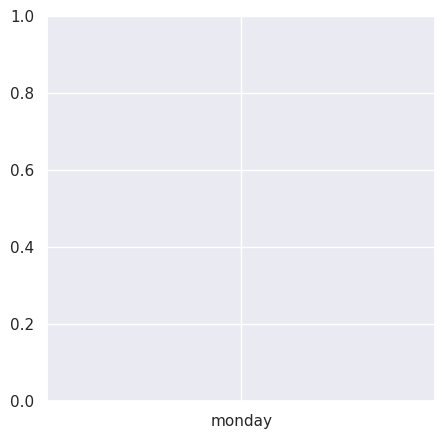

In [ ]:
pyplot.figure(figsize = (5, 5))
pyplot.scatter(x = "monday", y = "reaction_count", data = trainData) #for i in range n
pyplot.xlabel("x_i")
pyplot.ylabel("y")
pyplot.show()

Scatter plot of $\vec{x_i}$ against $\vec{x_j}$,

$i = 0, ..., n - 1$,

$j = 0, ..., n - 1$

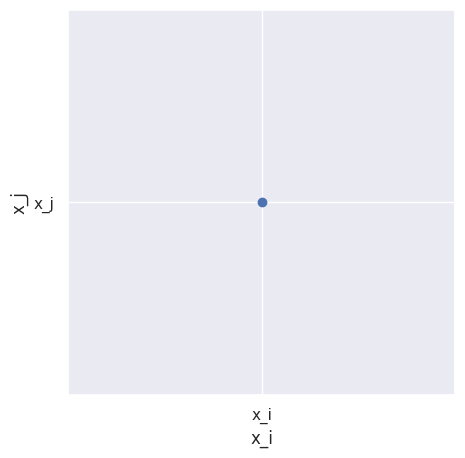

In [ ]:
pyplot.figure(figsize = (5, 5))
pyplot.scatter(x = "x_i", y = "x_j", data = data) #for i in range n: for j in range n
pyplot.xlabel("x_i")
pyplot.ylabel("x_j")
pyplot.show()

Bar graph of $x_i$ distribution, $\, i = 0, ..., n - 1$

In [ ]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   has_player_mention      1584 non-null   bool   
 1   is_umorous              1584 non-null   bool   
 2   is_controversial_topic  1584 non-null   bool   
 3   contains_good_deed      1584 non-null   bool   
 4   mention_match           1584 non-null   bool   
 5   image_count             1584 non-null   int64  
 6   has_image               1584 non-null   bool   
 7   has_with                1584 non-null   bool   
 8   Hour                    1584 non-null   int64  
 9   Day of week             1584 non-null   int64  
 10  Date                    1584 non-null   int64  
 11  Month                   1584 non-null   int64  
 12  Year                    1584 non-null   int64  
 13  avgLast5                1584 non-null   float64
 14  minLast5                1584 non-null   

In [ ]:
figure = seaborn.displot(data["maxAllTime"]) #for i in range n
figure.fig.set_size_inches(8, 6)

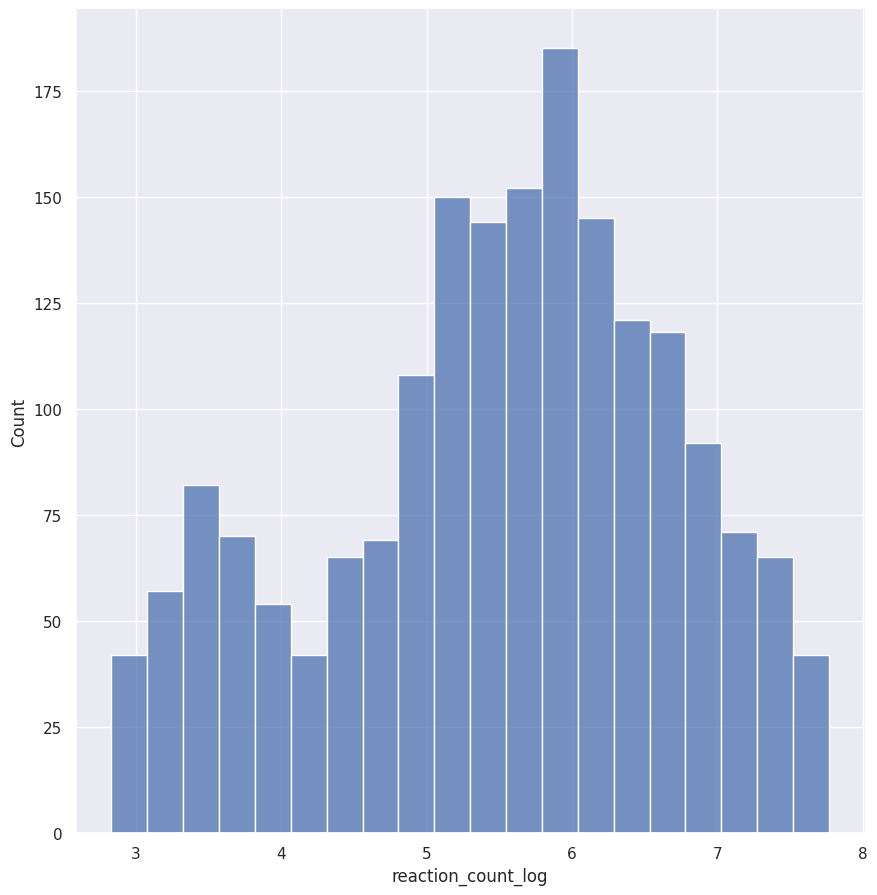

In [ ]:
figure = seaborn.displot(rawData["reaction_count_log"]) #for i in range n
figure.fig.set_size_inches(10, 10)

Bar graph of $y$ distribution

In [ ]:
seaborn.displot(data, x = "y")

Distribution of $x_i$ and $y$ log transformed

In [ ]:
pandas.Series(numpy.log1p(data["x_i"])).plot(kind = "density", figzide = (10, 4))

Box graph of $y$

In [ ]:
pandas.Series(data["y"]).plot(kind = "box", figsize = (10, 4), vert = False)

In [ ]:
pandas.Series(numpy.log1p(data["y"])).plot(kind = "box", figsize = (10, 4), vert = False)

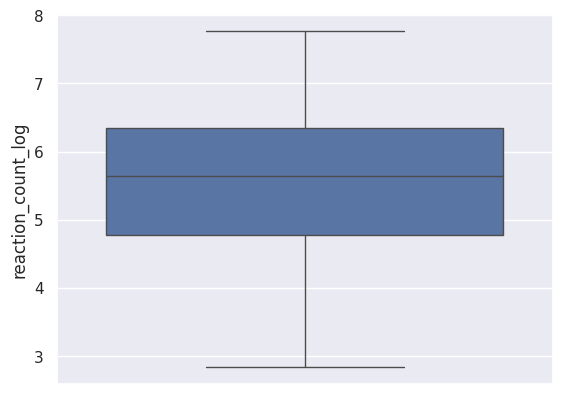

In [ ]:
plot = seaborn.boxplot(rawData["reaction_count_log"])

Data correlation map

In [ ]:
categoricalColumns = ["Day of week"]

trainDataCorr = pandas.get_dummies(rawData, categoricalColumns)

pyplot.figure(figsize = (60, 60))
seaborn.heatmap(trainDataCorr.corr(), annot = True)

In [ ]:
seaborn.pairplot(trainData.corr())
pyplot.show()

In [ ]:
seaborn.pairplot(trainData)

### Data processing

In [ ]:
rawData.info()

In [329]:
data = rawData

Apply log transformation (DO NOT RUN)

In [171]:
data["reaction_count_log"] = numpy.log1p(data["reaction_count"])
# data["avgLast5"] = numpy.log1p(data["avgLast5"])
# data["minLast5"] = numpy.log1p(data["minLast5"])
# data["maxLast5"] = numpy.log1p(data["maxLast5"])
# data["captionLength"] = numpy.log1p(data["captionLength"])

In [ ]:
for i in range(len(data["reaction_count_log"])):
    print(numpy.exp(data["reaction_count_log"].iloc[i]) - 1, rawData["reaction_count"].iloc[i])

Removing outliers (DO NOT RUN)

In [ ]:
data = data.loc[rawData[] >= 0.9]

Dropping null and non-unique columns

In [324]:
for column in data.columns:
    if len(data[column].unique()) == 1:
        print(column)
        data.drop(column, axis = 1, inplace = True)

data = data.dropna()
data.reset_index(drop = True, inplace = True)

data.drop(["reaction_count"], axis = 1, inplace = True)

In [330]:
for column in data.columns:
    if len(data[column].unique()) == 1:
        print(column)
        data.drop(column, axis = 1, inplace = True)

data = data.dropna()
data.reset_index(drop = True, inplace = True)

was_live
fanpage_name
fanpage_followers
fanpage_created_time


In [ ]:
data.info()

Categorical Encoding

In [ ]:
categoricalColumns = []

encoder = sklearn.preprocessing.OneHotEncoder(sparse_output=False)

newDataFrame = encoder.fit_transform(data[categoricalColumns])

one_hot_df = pandas.DataFrame(newDataFrame, columns = encoder.get_feature_names_out(categoricalColumns))

data = pandas.concat([data, one_hot_df], axis = 1)

data = data.drop(categoricalColumns, axis = 1)

Label Encoding

In [173]:
categoricalColumns = ["Day of week"]

for i in categoricalColumns:
    data[i] = sklearn.preprocessing.LabelEncoder().fit_transform(data[i])

train, test split

In [174]:
trainData, testData = sklearn.model_selection.train_test_split(data, test_size = 0.2, random_state = 42)

trainData.reset_index(drop = True, inplace = True)
testData.reset_index(drop = True, inplace = True)

In [ ]:
trainData.info()

In [175]:
label = "reaction_count_log"

trainYRegression = trainData[label]
trainX = copy.deepcopy(trainData)
trainX.pop(label)

testYRegression = testData[label]
testX = copy.deepcopy(testData)
testX.pop(label)

trainYClassification, testYClassification = yRegressionToClassification(trainData, testData, 10, label)

print(trainX.shape, trainYRegression.shape, trainYClassification.shape, testX.shape, testYRegression.shape, testYClassification.shape)

(1267, 66) (1267,) (1267,) (317, 66) (317,) (317,)


Standardize

In [176]:
standardScaler = sklearn.preprocessing.StandardScaler()
standardScaler.fit(trainX)
trainX = pandas.DataFrame(standardScaler.transform(trainX), columns = trainX.columns)
testX = pandas.DataFrame(standardScaler.transform(testX), columns = trainX.columns)

Normalization (DEPRECATED)

In [ ]:
normalizer = sklearn.preprocessing.MinMaxScaler().fit(trainX)
trainX = pandas.DataFrame(normalizer.transform(trainX), columns = trainX.columns)
testX = pandas.DataFrame(normalizer.transform(testX), columns = trainX.columns)

INFO

In [ ]:
trainX

### Models and feature importances

In [ ]:
print(numpy.median(testYRegression))
print(numpy.average(testYRegression))
print(numpy.var(testYRegression))

359.0
500.09148264984225
203650.48058991533


Gradient Boosting Regression

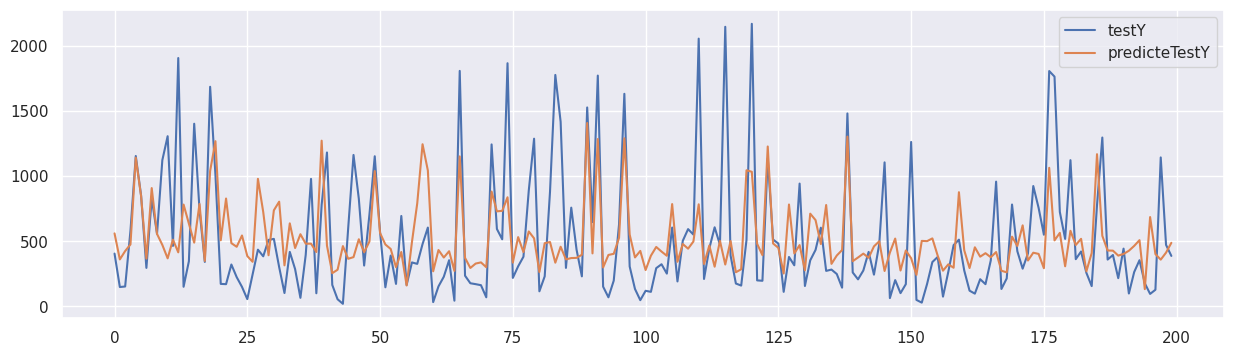

In [ ]:
figure = pyplot.figure()
figure.set_figwidth(15)
figure.set_figheight(4)

pyplot.plot(testYRegression[:200], label = "testY")
pyplot.plot(lightGBMModel.predict(testX)[:200], label = "predicteTestY")
pyplot.legend()
pyplot.show()

In [ ]:
lightGBMModel = lightgbm.LGBMRegressor(n_estimators = 404, num_leaves = 6, learning_rate = 0.01, boosting_type = 'gbdt', verbose = -1, random_state = 69) # Hyperparameter

lightGBMModel.fit(trainX, trainYRegression)

print(sklearn.metrics.mean_absolute_percentage_error(numpy.exp(testYRegression) - 1, numpy.exp(lightGBMModel.predict(testX)) - 1) * 100)
print(sklearn.metrics.mean_absolute_error(numpy.exp(testYRegression) - 1, numpy.exp(lightGBMModel.predict(testX)) - 1))
print(sklearn.metrics.r2_score(numpy.exp(testYRegression) - 1, numpy.exp(lightGBMModel.predict(testX)) - 1))
print(sklearn.metrics.mean_absolute_percentage_error(testYRegression, lightGBMModel.predict(testX)) * 100)
print(sklearn.metrics.mean_absolute_error(testYRegression - 1, lightGBMModel.predict(testX) - 1))
print(sklearn.metrics.r2_score(testYRegression, lightGBMModel.predict(testX)))


featureImportances = pandas.DataFrame({'Value':lightGBMModel.feature_importances_,'Feature':trainX.columns})

print(featureImportances.loc[featureImportances["Value"] == 0])
lightgbm.plot_importance(lightGBMModel, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")

In [ ]:
lightGBMModel = lightgbm.LGBMRegressor(verbose = -1) # Hyperparameter

lightGBMModel.fit(trainX, trainYRegression)

print(sklearn.metrics.mean_absolute_percentage_error(testYRegression, lightGBMModel.predict(testX)) * 100)
print(sklearn.metrics.mean_absolute_error(testYRegression, lightGBMModel.predict(testX)))

gridParams = {
    'learning_rate': [0.01],
    'num_leaves': list(range(5, 35)),
    'boosting_type' : ['gbdt'],
    'eval_metric':['mean_squared_error'],
    'n_estimators': list(range(280, 420)),
    'random_state': [69]
    }

randomizedSearch = sklearn.model_selection.RandomizedSearchCV(lightGBMModel, gridParams, cv = 6, scoring = 'neg_mean_squared_error', n_iter = 50, verbose = 3)

randomizedSearch.fit(trainX, trainYRegression)

print(randomizedSearch.best_params_)
print(randomizedSearch.best_score_)

In [ ]:
trainData.info()

In [ ]:
len([0] + numpy.linspace(0.0001, 0.0009, 9).tolist() + numpy.linspace(0.001, 0.009, 9).tolist() + numpy.linspace(0.01, 0.09, 9).tolist() + numpy.linspace(0.1, 0.9, 9).tolist() + numpy.linspace(1, 9, 9).tolist() + [10])

47

### Hyperparameter optimization and chooosing model

In [34]:
logUniformIncludesZero = [0] + numpy.linspace(0.0001, 0.0009, 9).tolist() + numpy.linspace(0.001, 0.009, 9).tolist() + numpy.linspace(0.01, 0.09, 9).tolist() + numpy.linspace(0.1, 0.9, 9).tolist() + numpy.linspace(1, 9, 9).tolist() + [10]

In [35]:
def customMAE(y_true, y_pred):
    return 'customMAE', sklearn.metrics.mean_absolute_error(y_true, y_pred), False

def optunaObjectiveMAE(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log = True),
        'num_leaves': trial.suggest_int("num_leaves", 5, 101),
        'n_estimators': trial.suggest_int("n_estimators", 10, 501),
        'reg_alpha': trial.suggest_categorical('reg_alpha', logUniformIncludesZero),
        'reg_lambda': trial.suggest_categorical('reg_lambda', logUniformIncludesZero),
        'min_child_samples': trial.suggest_int("min_child_samples", 10, 101),
        'n_jobs': trial.suggest_categorical('n_jobs', [2]),
        'random_state': trial.suggest_categorical('random_state', [69]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        'verbose': trial.suggest_categorical('verbose', [-1]),
    }

    thisLightGBMModel = lightgbm.LGBMRegressor(metric = "None", **params)

    kFold = sklearn.model_selection.KFold(n_splits = 6, shuffle = True, random_state = 420)

    loss = []

    for trainIndex, validationIndex in kFold.split(trainX):
        trainX_cv, validationX_cv = trainX.iloc[trainIndex], trainX.iloc[validationIndex]
        trainY_cv, validationY_cv = trainYRegression.iloc[trainIndex], trainYRegression.iloc[validationIndex]

        thisLightGBMModel.fit(trainX_cv, trainY_cv, eval_metric = customMAE)

        loss.append(sklearn.metrics.mean_absolute_error(validationY_cv, thisLightGBMModel.predict(validationX_cv)))

    return numpy.mean(loss)

In [36]:
def customMSE(y_true, y_pred):
    return 'customMSE', sklearn.metrics.mean_squared_error(y_true, y_pred), False

def optunaObjectiveMSE(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log = True),
        'num_leaves': trial.suggest_int("num_leaves", 5, 101),
        'n_estimators': trial.suggest_int("n_estimators", 10, 501),
        'reg_alpha': trial.suggest_categorical('reg_alpha', logUniformIncludesZero),
        'reg_lambda': trial.suggest_categorical('reg_lambda', logUniformIncludesZero),
        'min_child_samples': trial.suggest_int("min_child_samples", 10, 101),
        'n_jobs': trial.suggest_categorical('n_jobs', [2]),
        'random_state': trial.suggest_categorical('random_state', [69]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        'verbose': trial.suggest_categorical('verbose', [-1]),
    }

    thisLightGBMModel = lightgbm.LGBMRegressor(metric = "None", **params)

    kFold = sklearn.model_selection.KFold(n_splits = 6, shuffle = True, random_state = 420)

    loss = []

    for trainIndex, validationIndex in kFold.split(trainX):
        trainX_cv, validationX_cv = trainX.iloc[trainIndex], trainX.iloc[validationIndex]
        trainY_cv, validationY_cv = trainYRegression.iloc[trainIndex], trainYRegression.iloc[validationIndex]

        thisLightGBMModel.fit(trainX_cv, trainY_cv, eval_metric = customMSE)

        loss.append(sklearn.metrics.mean_absolute_error(validationY_cv, thisLightGBMModel.predict(validationX_cv)))

    return numpy.mean(loss)

In [53]:
def customMAPE(y_true, y_pred):
    return 'customMSE', sklearn.metrics.mean_absolute_percentage_error(y_true, y_pred), False

def optunaObjectiveMAPE(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log = True),
        'num_leaves': trial.suggest_int("num_leaves", 5, 101),
        'n_estimators': trial.suggest_int("n_estimators", 10, 501),
        'reg_alpha': trial.suggest_categorical('reg_alpha', logUniformIncludesZero),
        'reg_lambda': trial.suggest_categorical('reg_lambda', logUniformIncludesZero),
        'min_child_samples': trial.suggest_int("min_child_samples", 10, 101),
        'n_jobs': trial.suggest_categorical('n_jobs', [2]),
        'random_state': trial.suggest_categorical('random_state', [69]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        'verbose': trial.suggest_categorical('verbose', [-1]),
    }

    thisLightGBMModel = lightgbm.LGBMRegressor(metric = "None", **params)

    kFold = sklearn.model_selection.KFold(n_splits = 6, shuffle = True, random_state = 420)

    loss = []

    for trainIndex, validationIndex in kFold.split(trainX):
        trainX_cv, validationX_cv = trainX.iloc[trainIndex], trainX.iloc[validationIndex]
        trainY_cv, validationY_cv = trainYRegression.iloc[trainIndex], trainYRegression.iloc[validationIndex]

        thisLightGBMModel.fit(trainX_cv, trainY_cv, eval_metric = customMAPE)

        loss.append(sklearn.metrics.mean_absolute_error(validationY_cv, thisLightGBMModel.predict(validationX_cv)))

    return numpy.mean(loss)

In [41]:
data = rawData

In [ ]:
rawData.info()

In [59]:
def writeLog(string):
    logFile = open("log.txt", "a")
    logFile.write(string)
    logFile.close()
    print(string, end = "")

#from IPython.display import Javascript
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

searchSpace = {
    "lossFunction": ["mae", "mse", "mape"],
    # "badColumns": [True, False],
    # "30": [True, False]
}

keys, values = zip(*searchSpace.items())
combinations = [dict(zip(keys, p)) for p in product(*values)]

result = list()

writeLog("\n\n\nStart optimizing\n")

for combination in combinations:
    writeLog(str(combination) + " ")
    try:
        rawData = pandas.read_csv(DATA_FILE_PATH)
    except:
        writeLog("Could not read file\n")
        rawData = pandas.DataFrame()
        break

    # if (combination["wordColumns"] == False):
    #     #wordColumns
    #     droppedColumns = rawData.columns[19:]

    #     try:
    #         rawData.drop(droppedColumns, axis = 1, inplace = True)
    #     except Exception as error:
    #         writeLog("Exception: " + str(error) + "\n")
    #         break

    if (True):
        #30
        droppedColumns = ["avgLast30", "minLast30", "maxLast30"]

        try:
            rawData.drop(droppedColumns, axis = 1, inplace = True)
        except Exception as error:
            writeLog("Exception: " + str(error) + "\n")
            break

    data = rawData

    for column in data.columns:
        if len(data[column].unique()) == 1:
            data.drop(column, axis = 1, inplace = True)

    data = data.dropna()
    data.reset_index(drop = True, inplace = True)

    trainData, testData = sklearn.model_selection.train_test_split(data, test_size = 0.2, random_state = 42)

    trainData.reset_index(drop = True, inplace = True)
    testData.reset_index(drop = True, inplace = True)

    label = "reaction_count"

    trainYRegression = trainData[label]
    trainX = copy.deepcopy(trainData)
    trainX.pop(label)

    testYRegression = testData[label]
    testX = copy.deepcopy(testData)
    testX.pop(label)

    trainYClassification, testYClassification = yRegressionToClassification(trainData, testData, 10, label)

    #objectiveFunction
    study = optuna.create_study(direction = "minimize")
    if (combination["lossFunction"] == "mae"):
        study.optimize(optunaObjectiveMAE, n_trials = 200)
    elif (combination["lossFunction"] == "mse"):
        study.optimize(optunaObjectiveMSE, n_trials = 200)
    else:
        study.optimize(optunaObjectiveMAPE, n_trials = 200)

    writeLog("Best params: " + str(study.best_trial.params) + " ")

    lightGBMModel = lightgbm.LGBMRegressor(**study.best_trial.params)
    lightGBMModel.fit(trainX, trainYRegression)

    result.append([
        sklearn.metrics.mean_absolute_error(testYRegression, lightGBMModel.predict(testX)),
        sklearn.metrics.mean_squared_error(testYRegression, lightGBMModel.predict(testX)),
        sklearn.metrics.mean_absolute_percentage_error(testYRegression, lightGBMModel.predict(testX)),
        sklearn.metrics.r2_score(testYRegression, lightGBMModel.predict(testX)),
    ])

    writeLog(str(result[-1]) + "\n")




Start optimizing
{'lossFunction': 'mae'} 

[I 2024-05-17 12:38:29,092] A new study created in memory with name: no-name-193fb584-49a7-4d8b-a748-5cadda55fb59
[I 2024-05-17 12:38:29,840] Trial 0 finished with value: 284.8028769339683 and parameters: {'learning_rate': 0.011179289065124531, 'num_leaves': 10, 'n_estimators': 380, 'reg_alpha': 0.00019999999999999998, 'reg_lambda': 1.0, 'min_child_samples': 90, 'n_jobs': 2, 'random_state': 69, 'subsample': 0.5, 'verbose': -1}. Best is trial 0 with value: 284.8028769339683.
[I 2024-05-17 12:38:30,827] Trial 1 finished with value: 290.9287218047625 and parameters: {'learning_rate': 0.042804855111078115, 'num_leaves': 35, 'n_estimators': 362, 'reg_alpha': 7.0, 'reg_lambda': 0.001, 'min_child_samples': 63, 'n_jobs': 2, 'random_state': 69, 'subsample': 0.5, 'verbose': -1}. Best is trial 0 with value: 284.8028769339683.
[I 2024-05-17 12:38:31,842] Trial 2 finished with value: 288.1788371201643 and parameters: {'learning_rate': 0.006295834453917011, 'num_leaves': 67, 'n_estimators': 147, 're

Best params: {'learning_rate': 0.016813486619951495, 'num_leaves': 8, 'n_estimators': 381, 'reg_alpha': 0, 'reg_lambda': 8.0, 'min_child_samples': 22, 'n_jobs': 2, 'random_state': 69, 'subsample': 0.7, 'verbose': -1} [247.85789629682728, 143038.91056059676, 1.1793292222579672, 0.2600935477805507]
{'lossFunction': 'mse'} 

[I 2024-05-17 12:43:11,837] A new study created in memory with name: no-name-ea5d8232-57e2-4211-872f-03bc266fba74
[I 2024-05-17 12:43:12,576] Trial 0 finished with value: 326.6139050356598 and parameters: {'learning_rate': 0.0013885763611354545, 'num_leaves': 61, 'n_estimators': 237, 'reg_alpha': 0.04, 'reg_lambda': 0.03, 'min_child_samples': 52, 'n_jobs': 2, 'random_state': 69, 'subsample': 1, 'verbose': -1}. Best is trial 0 with value: 326.6139050356598.
[I 2024-05-17 12:43:13,308] Trial 1 finished with value: 293.9308983789432 and parameters: {'learning_rate': 0.08405916509360456, 'num_leaves': 76, 'n_estimators': 250, 'reg_alpha': 0.0005, 'reg_lambda': 0.03, 'min_child_samples': 67, 'n_jobs': 2, 'random_state': 69, 'subsample': 0.8, 'verbose': -1}. Best is trial 1 with value: 293.9308983789432.
[I 2024-05-17 12:43:14,123] Trial 2 finished with value: 306.5421738185285 and parameters: {'learning_rate': 0.003050665936689012, 'num_leaves': 39, 'n_estimators': 283, 'reg_alpha': 0.006, 

Best params: {'learning_rate': 0.018970728989741167, 'num_leaves': 8, 'n_estimators': 449, 'reg_alpha': 0.05, 'reg_lambda': 8.0, 'min_child_samples': 14, 'n_jobs': 2, 'random_state': 69, 'subsample': 0.9, 'verbose': -1} [249.76098484941528, 145231.37518919428, 1.202416863368397, 0.24875244682693987]
{'lossFunction': 'mape'} 

[I 2024-05-17 12:50:50,810] A new study created in memory with name: no-name-d0d29f14-5e9c-4473-9264-4927a3a24857
[I 2024-05-17 12:50:55,150] Trial 0 finished with value: 265.09091276948226 and parameters: {'learning_rate': 0.020414361748174705, 'num_leaves': 39, 'n_estimators': 210, 'reg_alpha': 0.0003, 'reg_lambda': 7.0, 'min_child_samples': 16, 'n_jobs': 2, 'random_state': 69, 'subsample': 1, 'verbose': -1}. Best is trial 0 with value: 265.09091276948226.
[I 2024-05-17 12:50:56,021] Trial 1 finished with value: 289.4615861654666 and parameters: {'learning_rate': 0.004392395625781391, 'num_leaves': 91, 'n_estimators': 451, 'reg_alpha': 0.003, 'reg_lambda': 0.00039999999999999996, 'min_child_samples': 97, 'n_jobs': 2, 'random_state': 69, 'subsample': 0.5, 'verbose': -1}. Best is trial 0 with value: 265.09091276948226.
[I 2024-05-17 12:50:56,370] Trial 2 finished with value: 335.30271766339155 and parameters: {'learning_rate': 0.001290891764154638, 'num_leaves': 89, 'n_estimators': 164

Best params: {'learning_rate': 0.015764239710006307, 'num_leaves': 11, 'n_estimators': 358, 'reg_alpha': 0.9, 'reg_lambda': 6.0, 'min_child_samples': 21, 'n_jobs': 2, 'random_state': 69, 'subsample': 0.5, 'verbose': -1} [249.82096614178684, 147405.75094999836, 1.1965807332219849, 0.23750491530797646]


In [60]:
for i in range(len(combinations)):
    print(combinations[i], result[i])

{'lossFunction': 'mae'} [247.85789629682728, 143038.91056059676, 1.1793292222579672, 0.2600935477805507]
{'lossFunction': 'mse'} [249.76098484941528, 145231.37518919428, 1.202416863368397, 0.24875244682693987]
{'lossFunction': 'mape'} [249.82096614178684, 147405.75094999836, 1.1965807332219849, 0.23750491530797646]


In [ ]:
losses = list()

In [ ]:
data = rawData



def customMAE(y_true, y_pred):
    return 'customMAE', sklearn.metrics.mean_absolute_error(y_true, y_pred), False

trainData, testData = sklearn.model_selection.train_test_split(data, test_size = 0.2, random_state = 42)

label = "reaction_count"

trainYRegression = trainData[label]
trainX = copy.deepcopy(trainData)
trainX.pop(label)

testYRegression = testData[label]
testX = copy.deepcopy(testData)
testX.pop(label)

params = {'learning_rate': 0.016813486619951495, 'num_leaves': 8, 'n_estimators': 381, 'reg_alpha': 0, 'reg_lambda': 8.0, 'min_child_samples': 22, 'n_jobs': 2, 'random_state': 69, 'subsample': 0.7, 'verbose': -1}

thisLightGBMModel = lightgbm.LGBMRegressor(metric = "None", **params)

kFold = sklearn.model_selection.KFold(n_splits = 6, shuffle = True, random_state = 420)

loss = []

for trainIndex, validationIndex in kFold.split(trainX):
    trainX_cv, validationX_cv = trainX.iloc[trainIndex], trainX.iloc[validationIndex]
    trainY_cv, validationY_cv = trainYRegression.iloc[trainIndex], trainYRegression.iloc[validationIndex]

    thisLightGBMModel.fit(trainX_cv, trainY_cv, eval_metric = customMAE)

    loss.append(sklearn.metrics.mean_absolute_error(validationY_cv, thisLightGBMModel.predict(validationX_cv)))

thisLightGBMModel = lightgbm.LGBMRegressor(metric = "None", **params)

thisLightGBMModel.fit(trainX, trainYRegression, eval_metric = customMAE)

print(loss)

print(numpy.mean(loss))

print(sklearn.metrics.r2_score(testYRegression, thisLightGBMModel.predict(testX)))
print(sklearn.metrics.mean_absolute_error(trainYRegression, thisLightGBMModel.predict(trainX)))

featureImportances = pandas.DataFrame({'Value':thisLightGBMModel.feature_importances_,'Feature':trainX.columns})

print(featureImportances.loc[featureImportances["Value"] == 0])
lightgbm.plot_importance(thisLightGBMModel, importance_type="gain", figsize=(12,6), title="LightGBM Feature Importance (Gain)")

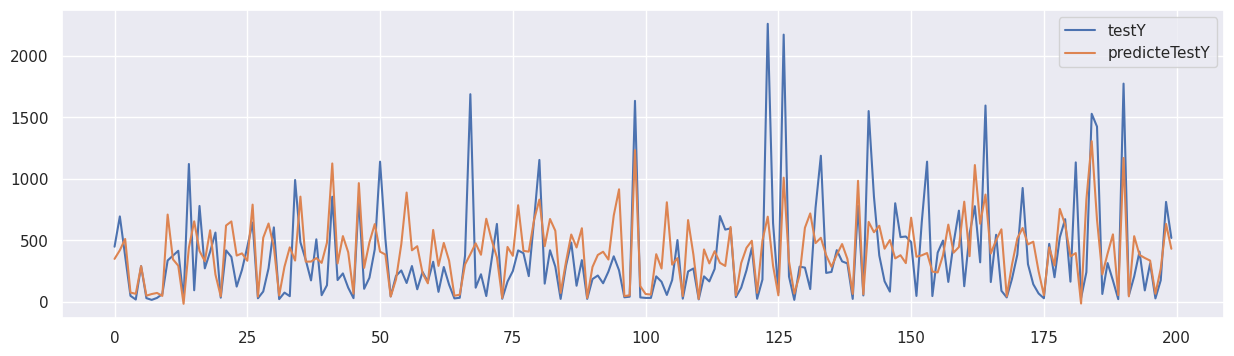

In [142]:
figure = pyplot.figure()
figure.set_figwidth(15)
figure.set_figheight(4)

pyplot.plot(numpy.array(testYRegression)[:200], label = "testY")
pyplot.plot(thisLightGBMModel.predict(testX)[:200], label = "predicteTestY")
pyplot.legend()
pyplot.show()

In [151]:
print(sklearn.metrics.mean_squared_error(testYRegression, numpy.array(numpy.array(data["avgAllTime"]))))

194870.83070165684


In [119]:
numpy.var(loss)

304.971152727877

Hyperparameter optimization using Randomized Search and K-fold

Changing dataset: One-hot encoding vs numeric

Changing loss function

Regression vs Classification model

### Other plots and graphs

Compare multiple models

In [ ]:
modelList = list()

trainingLoss = modelList["trainingLoss"]
testingLoss = modelList["testingLoss"]

pyplot.figure(figsize(11, 11))
pyplot.bar(numpy.arange(len(modelList)) - 0.2, trainingLoss, width = 0.4, label = "training", color = "black")
pyplot.bar(numpy.arange(len(modelList)) + 0.2, testingLoss, width = 0.4, label = "testing", color = "blue")
pyplot.xticks(numpy.arange(len(modelList)), modelList["name"])
pyplot.xlabel("models")
pyplot.ylabel("loss")
pyplot.legend()
pyplot.show()

Feature importances

Log transform of $\vec{y}$

$\vec{y_\star}$ vs $\vec{y}$

$\vec{y_\star}$ vs $\vec{y}$ (log transformed)

### Deep learning

In [75]:
from tensorflow import keras

inputs = keras.Input(shape = (46, ), name = "input")
layer1 = keras.layers.Dense(units = 100, activation = "relu", name = "layer1")(inputs)
layer2 = keras.layers.Dense(units = 100, activation = "relu", name = "layer2")(layer1)
layer3 = keras.layers.Dense(units = 100, activation = "relu", name = "layer3")(layer2)
outputs = keras.layers.Dense(units = 1, name = "output", activation = "relu")(layer3)
model = keras.Model(inputs = inputs, outputs = outputs, name = "wwwww")
model.summary()

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    loss = keras.losses.MeanSquaredError(),
    metrics = ["mape"],
)

Model: "wwwww"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 46)]              0         
                                                                 
 layer1 (Dense)              (None, 100)               4700      
                                                                 
 layer2 (Dense)              (None, 100)               10100     
                                                                 
 layer3 (Dense)              (None, 100)               10100     
                                                                 
 output (Dense)              (None, 1)                 101       
                                                                 
Total params: 25001 (97.66 KB)
Trainable params: 25001 (97.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
trainData, testData = sklearn.model_selection.train_test_split(data, test_size = 0.2, random_state = 42)

trainData.reset_index(drop = True, inplace = True)
testData.reset_index(drop = True, inplace = True)

label = "reaction_count"

trainYRegression = trainData[label]
trainX = copy.deepcopy(trainData)
trainX.pop(label)

testYRegression = testData[label]
testX = copy.deepcopy(testData)
testX.pop(label)

0      449
1      695
2      373
3       50
4       20
      ... 
369     19
370    236
371     31
372     18
373     21
Name: reaction_count, Length: 374, dtype: int64

In [ ]:
model.fit(trainX, trainYRegression, batch_size = 32, epochs = 100, verbose = 2)

In [78]:
print(sklearn.metrics.mean_absolute_error(testYRegression, model.predict(testX)),
sklearn.metrics.mean_squared_error(testYRegression, model.predict(testX)),
sklearn.metrics.mean_absolute_percentage_error(testYRegression, model.predict(testX)),
sklearn.metrics.r2_score(testYRegression, model.predict(testX)))

12/12 [==============================] - 0s 2ms/step
274.8533917098122 169737.2115046746 1.1758525741036916 0.12198955178114634
